In [34]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

```
FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(50304, 2048)
    (h): ModuleList(
      (0-23): 24 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): FalconLinear(in_features=2048, out_features=6144, bias=True)
          (dense): FalconLinear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): FalconLinear(in_features=2048, out_features=8192, bias=True)
          (act): GELU(approximate='none')
          (dense_4h_to_h): FalconLinear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2048, out_features=50304, bias=False)
)
```

In [35]:
# These are the path1 and path2 of some particular transformer in the ModuleList
# The hidden state before the transformer before the transformer does its transformation
path1 = torch.load('../scripts/inputs_0_0.pt')
# The hidden state after the transformation
path2 = torch.load('../scripts/outputs_0_23.pt')

In [36]:
print(torch.norm(path1[0][0] - path2[0][0]))

tensor(1408.6417, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [37]:
print(path1[0][1])
print(path2[0][1])

tensor([ 1.9574,  2.0025,  0.4716,  ..., -1.7297, -1.2015, -0.3173],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 3.2687,  4.2937,  3.5464,  ...,  0.9641, -4.1393, -3.2016],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [38]:
print(f'Number of paths:       {path1.shape[0]}')
print(f'Length of path:        {path1.shape[1]}')
print(f'Dim of points on path: {path1.shape[2]}')
number_of_paths = path1.shape[0]
length_of_path = path1.shape[1]
dim_of_points_on_path = path1.shape[2]

Number of paths:       4
Length of path:        17
Dim of points on path: 2048


In [39]:
# Remove the first entry of the path
path1 = path1[:, 1:, :]
path2 = path2[:, 1:, :]

In [40]:
# Flatten the data into just a list of points
path1_points = path1.reshape(-1, 2048)
path2_points = path2.reshape(-1, 2048)

In [41]:
# Make sure that the flattening works as expected
torch.norm(path1[2, 7, :] - path1_points.reshape(number_of_paths, length_of_path-1, -1)[2, 7, :])

tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [42]:
# Whiten the data
path1_points = (path1_points - path1_points.mean(dim=0, keepdim=True))/path1_points.std(dim=0, keepdim=True)
path2_points = (path2_points - path2_points.mean(dim=0, keepdim=True))/path2_points.std(dim=0, keepdim=True)

In [43]:
# project the path1_points to two dimensions using pca in pytorch using svd
_,S1,V1 = torch.svd_lowrank(path1_points, q=20)
_,S2,V2 = torch.svd_lowrank(path2_points, q=20)

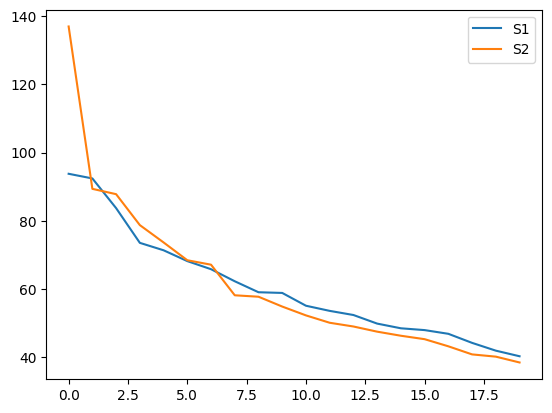

In [44]:
plt.plot(S1.cpu().detach(), label='S1')
plt.plot(S2.cpu().detach(), label='S2')
plt.legend()

In [45]:
# project the input points to two dimensions
path1_points_2d = torch.matmul(path1_points, V1[:,:2]) 
path2_points_2d = torch.matmul(path2_points, V2[:,:2]) 

In [46]:
def align(X, Y):
    # Try to make the input and the output as close as possible  
    # XW=Y
    W = torch.inverse(X.T @ X) @ X.T @ Y 
    print(torch.norm(X - Y))
    X = X @ W
    print(torch.norm(X - Y))
    return X

In [47]:
# path1_points_2d = align(path1_points_2d, path2_points_2d)

In [48]:
# Ok, now go back to the original shapes for plotting
path1_points_2d = path1_points_2d.reshape(number_of_paths, length_of_path-1, -1).cpu().detach()
path2_points_2d = path2_points_2d.reshape(number_of_paths, length_of_path-1, -1).cpu().detach()

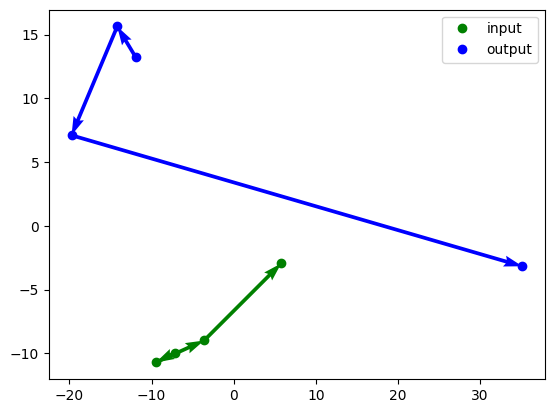

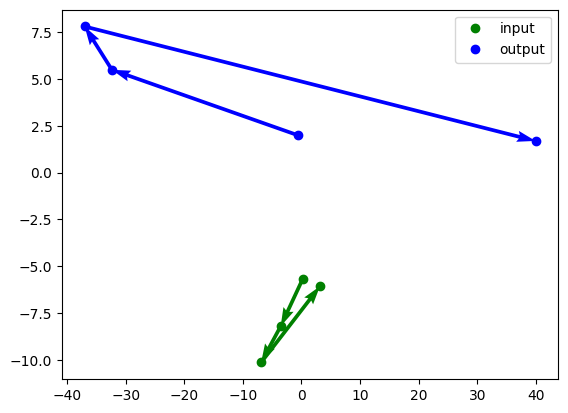

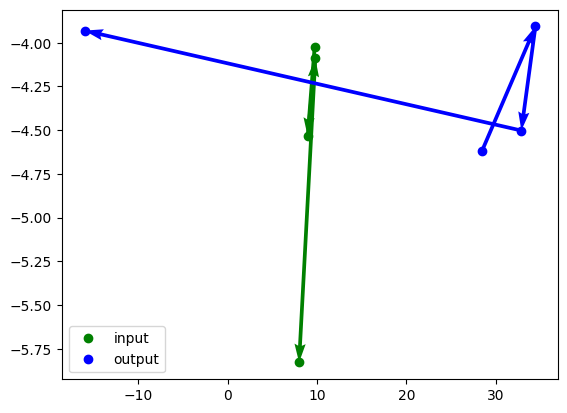

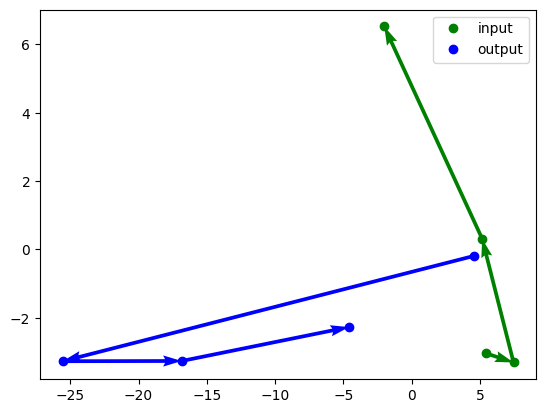

In [49]:
plot_range = torch.arange(0, 4)
# plot_range = torch.arange(0, path1_points_2d.shape[1])

for i in range(4):
    plt.plot(path1_points_2d[i, plot_range, 0], 
             path1_points_2d[i, plot_range, 1], 
             'o', color='g', label='input')
    x = path1_points_2d[i, plot_range, 0]
    y = path1_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='g', angles='xy', scale_units='xy', scale=1)

    plt.plot(path2_points_2d[i, plot_range ,0], 
             path2_points_2d[i, plot_range, 1], 
             'o', color='b', label='output')
    x = path2_points_2d[i, plot_range, 0]
    y = path2_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='b', angles='xy', scale_units='xy', scale=1)


    plt.legend()
    plt.show()
